In [103]:
import boto3
import json
from datasets import Dataset, load_dataset
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sal.utils.math import (
    find_majority_answer, extract_completion_answers,
    memoized_canonical_form, find_answer_with_largest_sum,
    strip_string
)

def download_and_load_json(full_path, local_path):
    file_dir = full_path
    bucket_name, key = file_dir.replace('s3://', '').split('/', 1)
    s3 = boto3.client('s3')
    # Remove local_path if it exists
    try:
        os.remove(local_path)
    except OSError:
        pass
    try:
        s3.download_file(bucket_name, key, local_path)
    except Exception as e:
        print(f"Error downloading file: {e}")
        print(key)

    # print(f"File downloaded to {local_path}")
    model_responses = []
    with open(local_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        return data

def extract_answer(pred_str):
    pred_str = pred_str.replace("\u043a\u0438", "")

    if "boxed" in pred_str:
        ans = pred_str.split("boxed")[-1]
        if len(ans) == 0:
            a = ""
        elif ans[0] == "{":
            stack = 1
            a = ""
            for c in ans[1:]:
                if c == "{":
                    stack += 1
                    a += c
                elif c == "}":
                    stack -= 1
                    if stack == 0:
                        break
                    a += c
                else:
                    a += c
        else:
            a = ans.split("$")[0].strip()
        pred = a
    else:
        return pred_str
    return pred



In [104]:
def get_judge_prompt_with_gt(question, target, response, incorrect_options=None, cot=True):
    """
    Generate a prompt for the judge with ground truth.
    
    Args:
        question: The question being asked
        target: The ground truth answer
        response: The response to judge
        incorrect_options: Optional string containing incorrect options
        cot: Whether to use a COT prompt
        
    Returns:
        A formatted prompt string for the judge
    """
    # The response can have more information than the ground-truth. It can be more specific (for example, "Labrador" is more specific than "dog"), or have additional possible answers. But it must cover everything mentioned in the ground-truth. It is okay if it covers it in different words, i.e. paraphrased.

    prompt = f"""Your task is to judge whether the given response to a question matches a given ground truth answer or not. You are provided with a question, a ground truth response, and the response you need to judge.
For a response to "match", it must have at least as much information as the ground-truth. 
The response can have more information than the ground-truth. It can be more specific (for example, "Labrador" is more specific than "dog"), or have additional possible correct answers. But it must cover everything mentioned in the ground-truth. It is okay if it covers it in different words, i.e. paraphrased. 
For numeric answers, the relative error, defined as |response - ground truth| / mean(response, ground truth), must be less than 1% for the response to be judged as a correct match. Here, if the ground truth is a specific numeric quantity but the response is a range, then they don't match (even if the range contains the ground truth).

Possible judgments:

"0": The response does not match the ground-truth answer.
"1": The response matches the ground-truth.

Question: "{question}"
Ground truth: "{target}"
"""

    if incorrect_options:
        prompt += f"\n{incorrect_options}"
        
    prompt += f"""Response: "{response}"

Your job is to ONLY check whether the given response matches the ground truth answer or not in the context of the question. You DO NOT NEED to assess the correctness of the response. This is part of an automated evaluation process, therefore you MUST OUTPUT your final answer as "0" or "1" in <answer> </answer> tags."""
    
    if cot:
        prompt += "\nThink step by step and end your response with <answer>0</answer> OR <answer>1</answer> TAGS."
    else :
        prompt += "\nYOU SHOULD ALWAYS END YOUR RESPONSE WITH <answer>0</answer> OR <answer>1</answer> TAGS."
        
# Think step by step and end your response with <answer>0</answer> OR <answer>1</answer> TAGS.
# YOU SHOULD ALWAYS END YOUR RESPONSE WITH <answer>0</answer> OR <answer>1</answer> TAGS.

    return prompt

In [105]:
import nflx_genai as genai
genai.project_id = "metafwlo"
client = genai.Client()

In [106]:
dataset_name = "Idavidrein/gpqa"
dataset_split = "train"
dataset = load_dataset(dataset_name, 'gpqa_diamond', split=dataset_split)

In [107]:
def build_message(request_id, body_message, model="gpt-4.1-mini", id_prefix=''):
    """
    Builds a newline-delimited JSON string for batch API requests.

    Args:
        request_id: A list of unique identifiers for each request.
        body_message: A list of user-facing messages or prompts.
        model: The model to be used for the chat completion.

    Returns:
        A single string where each line is a valid JSON object
        representing a request.
    """
    # Assertions are good for ensuring data integrity before processing
    assert isinstance(request_id, list), "request_id must be a list"
    assert isinstance(body_message, list), "body_message must be a list"
    assert len(request_id) == len(body_message), "request_id and body_message lists must have the same length"

    lines = []
    for r_id, b_msg in zip(request_id, body_message):
        # 1. Create a Python dictionary that represents the JSON structure
        data = {
            "custom_id": id_prefix + str(r_id),
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": model,
                "messages": [
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": b_msg}
                ]
            }
        }
        # 2. Serialize the dictionary to a JSON string.
        #    json.dumps() correctly handles escaping of special characters.
        lines.append(json.dumps(data))

    # 3. Join all the JSON strings with a newline character.
    #    This is much more efficient than repeated string concatenation.
    return '\n'.join(lines)


def upload_job(MSG):
    with open("/tmp/batch_input.jsonl", "w") as f:
        f.write(MSG)
    with open("/tmp/batch_input.jsonl", "rb") as f:
        res = client.files.create(
            file=f,
            purpose="batch"
        )
    batch_res = client.batches.create(
        completion_window="24h",
        input_file_id=res.id,
        endpoint="/v1/chat/completions",
    )
    return batch_res

In [108]:
len(dataset)

198

In [109]:
for QID in tqdm(range(50, len(dataset))):
    print(QID)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 195022.62it/s]

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197


In [109]:
job_dict = {}
save_dir = '/root/batch_job_log'

KeyboardInterrupt: 

In [113]:
job_dict_big = {}
save_dir = '/root/batch_job_log'

# for QID in tqdm(range(len(dataset))):
for QID in tqdm(range(192, len(dataset))):
    Q = dataset[QID]['Pre-Revision Question']
    A = dataset[QID]['Pre-Revision Correct Answer']
    all_answers = []
    qid = QID
    folder_name = 'dpsk_new_sample_long_long_with_final_answer_gpqa'
    all_seeds = [0, 1, 2, 3, 4, 5, 6, 7]
    # all_seeds = [1, 3]
    save_name = 'sdfsdfsd'
    for seed in all_seeds:
        # file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/dpsk_new_det_with_final_answer/seed_{seed}/answers_{qid}.json'
        file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/{folder_name}/seed_{seed}/answers_{qid}.json'
        F = download_and_load_json(file_dir, f'/tmp/answers_{save_name}.json')
        all_answers.append(F)

    all_answers = np.array(all_answers)
    all_answers = all_answers.transpose(1, 0, 2).reshape(-1, len(all_seeds) * 16)
    all_msg = ''

    for i, row in (list(enumerate(all_answers))[::2]):
        response = [extract_answer(_ans) for _ans in row]
        batch_MSG = build_message(
            request_id = list(range(len(response))),
            body_message = [get_judge_prompt_with_gt(Q, A, r) for r in response],
            id_prefix=f'q_{qid}_row_{i}_rollout'
        )
        all_msg += batch_MSG + '\n'

    job_id = upload_job(all_msg)
    job_dict_big[QID] = job_id.id

with open(f'{save_dir}/job_dict_gpqa_BIG.json', 'w') as f:
    json.dump(job_dict_big, f, indent=4)


  0%|                                                                                                                                                | 0/6 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:40<00:00, 16.73s/it]


In [111]:
len(dataset)

198

In [114]:
job_dict_big

{192: 'batch_6893d59688fc81909dda117219628b8d',
 193: 'batch_6893d5a0c8c48190a8d784f9e3bbc018',
 194: 'batch_6893d5ad95bc81909ba54a60eda29aa6',
 195: 'batch_6893d5bed2fc8190ad772265be7f5a75',
 196: 'batch_6893d5d594ac8190b0f7a7fe15b6f828',
 197: 'batch_6893d5e863ac81908081f56ac3a38d67'}

In [110]:
job_dict_big

{0: 'batch_6893c46a7cf48190bf96d044095bea04',
 1: 'batch_6893c47d63c88190921b37ff6a848a1d',
 2: 'batch_6893c495d5048190a5f9b64398053266',
 3: 'batch_6893c4a150908190aeca3fe1af44130a',
 4: 'batch_6893c4e1bcfc819084610ed32dca38da',
 5: 'batch_6893c4edfddc81909b066ded83a62592',
 6: 'batch_6893c4fabd048190b49248b35737bc0e',
 7: 'batch_6893c50f1444819092da22cb0cc9a2bb',
 8: 'batch_6893c52853a08190888b423d94f16fb0',
 9: 'batch_6893c5430cc881908923a87f6b2be4a7',
 10: 'batch_6893c546090481909cea713c84f9e4ad',
 11: 'batch_6893c55f03cc81908c8b281d88f4f144',
 12: 'batch_6893c56eeef081908b73c221b9fba1fa',
 13: 'batch_6893c57a6afc8190a58b14501874deec',
 14: 'batch_6893c5a663d08190ba89dffdaa9e45ab',
 15: 'batch_6893c5b965348190a76ee501d69edd8f',
 16: 'batch_6893c5c9d2508190807090ded445d82e',
 17: 'batch_6893c5d5d074819093a6a1c94ca2ed40',
 18: 'batch_6893c6198cbc8190a0df19f4c47662e3',
 19: 'batch_6893c62307b08190a1088357c062f5f8',
 20: 'batch_6893c63fd4048190929963a1ede4f051',
 21: 'batch_6893c647d41

In [ ]:
for QID in tqdm(range(50, len(dataset))):
# for QID in tqdm(range(50)):
    Q = dataset[QID]['Pre-Revision Question']
    A = dataset[QID]['Pre-Revision Correct Answer']

    all_answers = []
    qid = QID
    folder_name = 'dpsk_new_sample_long_long_with_final_answer_gpqa'
    # all_seeds = [1, 2, 3, 4, 5, 6, 7]
    all_seeds = [1, 3]
    save_name = 'sdfsdfsd'
    for seed in all_seeds:
        # file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/dpsk_new_det_with_final_answer/seed_{seed}/answers_{qid}.json'
        file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/{folder_name}/seed_{seed}/answers_{qid}.json'
        F = download_and_load_json(file_dir, f'/tmp/answers_{save_name}.json')
        all_answers.append(F)

    all_answers = np.array(all_answers)
    all_answers = all_answers.transpose(1, 0, 2).reshape(-1, len(all_seeds) * 16)
    all_msg = ''

    for i, row in tqdm(list(enumerate(all_answers))[::2]):
        response = [extract_answer(_ans) for _ans in row]
        batch_MSG = build_message(
            request_id = list(range(len(response))),
            body_message = [get_judge_prompt_with_gt(Q, A, r) for r in response],
            id_prefix=f'q_{qid}_row_{i}_rollout'
        )
        all_msg += batch_MSG + '\n'

    job_id = upload_job(all_msg)
    job_dict[QID] = job_id.id

# with open(f'{save_dir}/job_dict_gpqa_1.json', 'w') as f:
#     json.dump(job_dict, f, indent=4)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [17:50<00:00,  7.23s/it]


In [ ]:
job_dict

{0: 'batch_6893af195b5c81908b1bafdc5d77188c',
 1: 'batch_6893af1ca3ac81908b551f764b04eabc',
 2: 'batch_6893af1feac8819081b59444a9c0b9dc',
 3: 'batch_6893af22c2848190b353fa8687ed439c',
 4: 'batch_6893af254dc08190a514abf20cb1f925',
 5: 'batch_6893af28a6e88190aced99f390d5c433',
 6: 'batch_6893af2ba8c0819091fdad5a84ab080a',
 7: 'batch_6893af315e9881909829fe86e5437561',
 8: 'batch_6893af3550f8819094fea0edbf4169f8',
 9: 'batch_6893af398e6c8190ae213f1af3b65fa8',
 10: 'batch_6893af3b5a488190b6702abc41f49d92',
 11: 'batch_6893af426330819080819f6426dca70e',
 12: 'batch_6893af47609481909ac771e085fab1e6',
 13: 'batch_6893af4ae86c8190b7c209b22f889413',
 14: 'batch_6893af50740081909d4f578b180cfbae',
 15: 'batch_6893af5374508190a12cb918c8eb738a',
 16: 'batch_6893af567fe88190aa3550749e2ee733',
 17: 'batch_6893af59e2848190aeb2efbe9c22e781',
 18: 'batch_6893af5e0df08190a03a3fc8cc5ece61',
 19: 'batch_6893af63bd8881909ba0ef7d01bf31fb',
 20: 'batch_6893af66fff8819098592e0f26bad3df',
 21: 'batch_6893af69f25

In [ ]:
def view_job_results(job_id):
    completed_batch = client.batches.retrieve(
        batch_id=job_id
    )
    return completed_batch

def extract_results(job_id):
    completed_batch = client.batches.retrieve(
        batch_id=job_id
    )
    results = client.files.content(
        file_id=completed_batch.output_file_id
    )
    outputs = []
    for line in results.read().decode("utf-8").split("\n")[:-1]:
        line = json.loads(line)
        output = line['response']['body']['choices'][0]['message']['content']
        output = output.split('<answer>')[1].split('</answer>')[0]
        outputs.append(int(output))
    return np.array(outputs)

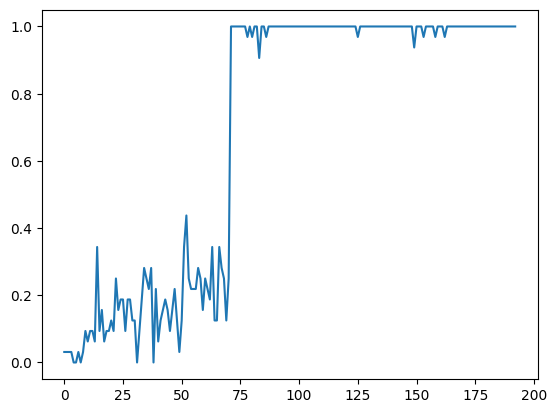

In [ ]:
plt.plot(extract_results(job_dict[41]).reshape(-1, 32).mean(-1))

In [ ]:
for k, v in job_dict.items():
    print(f"QID: {k}, Job status: {view_job_results(v).status}")

QID: 0, Job status: completed
QID: 1, Job status: completed
QID: 2, Job status: completed
QID: 3, Job status: completed
QID: 4, Job status: completed
QID: 5, Job status: completed
QID: 6, Job status: completed
QID: 7, Job status: completed
QID: 8, Job status: completed
QID: 9, Job status: completed
QID: 10, Job status: completed
QID: 11, Job status: completed
QID: 12, Job status: completed
QID: 13, Job status: completed
QID: 14, Job status: completed
QID: 15, Job status: completed
QID: 16, Job status: completed
QID: 17, Job status: completed
QID: 18, Job status: completed
QID: 19, Job status: completed
QID: 20, Job status: completed
QID: 21, Job status: completed
QID: 22, Job status: finalizing
QID: 23, Job status: completed
QID: 24, Job status: completed
QID: 25, Job status: completed
QID: 26, Job status: completed
QID: 27, Job status: completed
QID: 28, Job status: completed
QID: 29, Job status: completed
QID: 30, Job status: completed
QID: 31, Job status: completed
QID: 32, Job stat

In [ ]:
view_job_results(job_dict[20])['status']

Batch(id='batch_6893af66fff8819098592e0f26bad3df', completion_window='24h', created_at=1754509158, endpoint='/v1/chat/completions', input_file_id='file-VzWn7k45jjUqi7gUtu9eVL', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1754510380, error_file_id=None, errors=None, expired_at=None, expires_at=1754595558, failed_at=None, finalizing_at=1754510160, in_progress_at=1754509162, metadata=None, output_file_id='file-Hxh55uFFJXYZGt1nZikuQA', request_counts=BatchRequestCounts(completed=4896, failed=0, total=4896))

In [ ]:
completed_batch = client.batches.retrieve(
    batch_id=batch_res.id
)
completed_batch

In [ ]:
results = client.files.content(
    file_id=completed_batch.output_file_id
)
for line in results.read().decode("utf-8").split("\n")[:-1]:
    line = json.loads(line)
    output = line['response']['body']['choices'][0]['message']['content']
    output = output.split('<answer>')[1].split('</answer>')[0]
    print(output)

0
0
0
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
1
0
